<a href="https://colab.research.google.com/github/Nicolas-Nav/DeepLearning/blob/Nico/DLY0100_Entrega_1_nicogaby.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Nicolas Navarro
+ Gabriela Sandoval

**Correos Electrónicos:**

+ ni.navarroa@duoc.cl
+ g.sandoval@duoc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python ...

# Carga de datos

In [89]:
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


--2025-04-17 06:44:19--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.207, 173.194.174.207, 74.125.23.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  6.41MB/s    in 1.5s    

2025-04-17 06:44:21 (6.41 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-17 06:44:21--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.207, 173.194.174.207, 74.125.23.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [app

In [90]:
!ls -lh

total 55M
-rw-r--r-- 1 root root 2.2M Apr 17 05:01 hist_sgd_relu.keras
-rw-r--r-- 1 root root 2.3M Apr 17 06:22 modelo_final.keras
-rw-r--r-- 1 root root 6.6M Apr 17 06:41 modelo_mas_equilibrado.keras
-rw-r--r-- 1 root root 2.2M Apr 17 05:49 red_adam_batch256.keras
-rw-r--r-- 1 root root 2.2M Apr 17 05:47 red_adam_batch64.keras
-rw-r--r-- 1 root root 2.2M Apr 17 06:15 red_adam_dropout.keras
-rw-r--r-- 1 root root 2.2M Apr 17 05:45 red_adam_elu.keras
-rw-r--r-- 1 root root 2.2M Apr 17 05:59 red_adam_epoca.keras
-rw-r--r-- 1 root root 2.2M Apr 17 05:41 red_adam_relu.keras
-rw-r--r-- 1 root root 2.2M Apr 17 05:15 red_sgd_batch256.keras
-rw-r--r-- 1 root root 2.2M Apr 17 05:14 red_sgd_batch64.keras
-rw-r--r-- 1 root root 6.7M Apr 17 06:02 red_sgd_capa4.keras
-rw-r--r-- 1 root root 2.2M Apr 17 05:38 red_sgd_dropout.keras
-rw-r--r-- 1 root root 2.2M Apr 17 05:12 red_sgd_elu.keras
-rw-r--r-- 1 root root 2.2M Apr 17 05:32 red_sgd_epoca.keras
-rw-r--r-- 1 root root 2.2M Apr 17 05:10 red_sgd_rel

In [91]:
import gzip
import pandas as pd
import shutil
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
###
from keras.utils import to_categorical

from time import time

#Introduccion

Introducción: Descripción del problema y objetivo del modelo.


En este notebook se trabajará con el dataset MNIST, que contiene imágenes de dígitos escritos a mano (0–9). Como primer paso, es fundamental preprocesar los datos antes de entrenar una red neuronal.

Primero, cada imagen tiene un tamaño original de 28x28 píxeles, lo que significa que está compuesta por 784 valores (28×28). Para poder trabajar con estas imágenes en una red neuronal, debemos aplanarlas, es decir, se convierten en un vector de tamaño 784 en lugar de una matriz 2D.

Luego, las imágenes se normalizan, es decir, se dividen sus valores por 255 para que queden entre 0 y 1. Esto mejora la eficiencia del entrenamiento, ya que evita trabajar con números muy grandes que podrían afectar negativamente el cálculo de los gradientes durante el entrenamiento.

Por otra parte, las etiquetas que indican el número que representa cada imagen también deben ser procesadas. En este caso utilizaremos el one-hot encoding, lo que convierte, por ejemplo, un "3" en el vector [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]. Esto es necesario porque la red no puede trabajar directamente con números enteros como clases, ya que no entiende que son categorías y no cantidades.

El dataset incluye 60.000 imágenes para entrenamiento y 10.000 para prueba, lo que permite entrenar el modelo con muchos ejemplos y evaluarlo con datos nuevos para medir su capacidad de generalizar.

Finalmente, este preprocesamiento adapta correctamente las imágenes y etiquetas al formato que requiere la red neuronal para aprender de manera efectiva.

# Carga de imágenes

In [92]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


# Muestra imágenes

In [93]:
nombres = ['0','1','2','3','4','5','6','7','8','9']

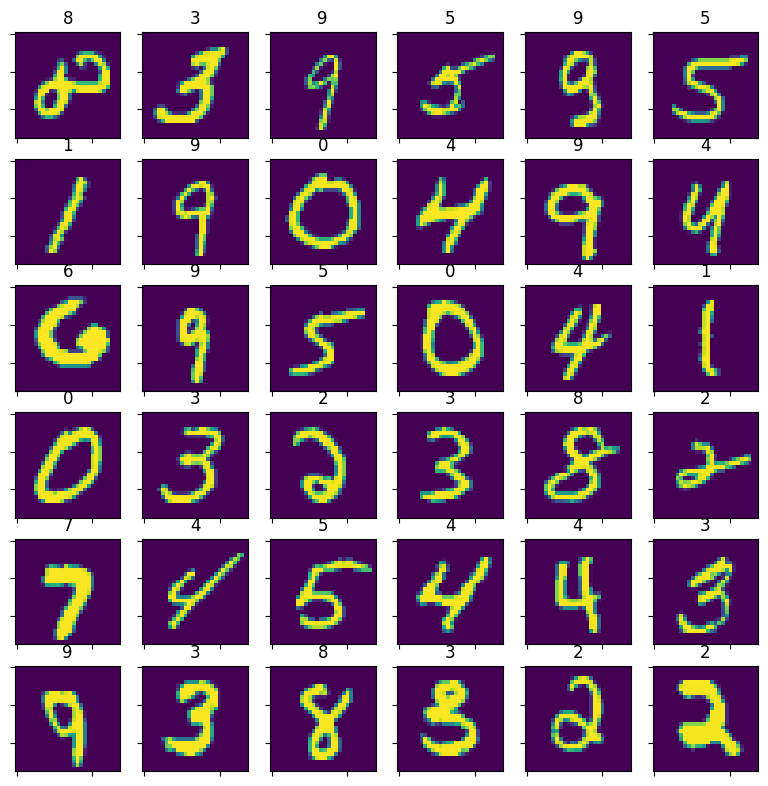

In [94]:
h = 6
w = 6
fig, axs = plt.subplots(h, w, figsize=(1.6*h,1.6*w))
for i in range(h):
  for j in range(w):
    ex = np.random.randint(0, X_train.shape[0])
    predicted_label = np.argmax(y_train[ex])
    axs[i,j].set_title(nombres[predicted_label])
    axs[i,j].grid(False)
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(X_train[ex].reshape(28, 28))

In [95]:
numimagen = np.sum(y_train, axis=0)

for i in range(10):
    print(f"Cantidad de imágenes del número {i}: {numimagen[i]}")

Cantidad de imágenes del número 0: 5923.0
Cantidad de imágenes del número 1: 6742.0
Cantidad de imágenes del número 2: 5958.0
Cantidad de imágenes del número 3: 6131.0
Cantidad de imágenes del número 4: 5842.0
Cantidad de imágenes del número 5: 5421.0
Cantidad de imágenes del número 6: 5918.0
Cantidad de imágenes del número 7: 6265.0
Cantidad de imágenes del número 8: 5851.0
Cantidad de imágenes del número 9: 5949.0


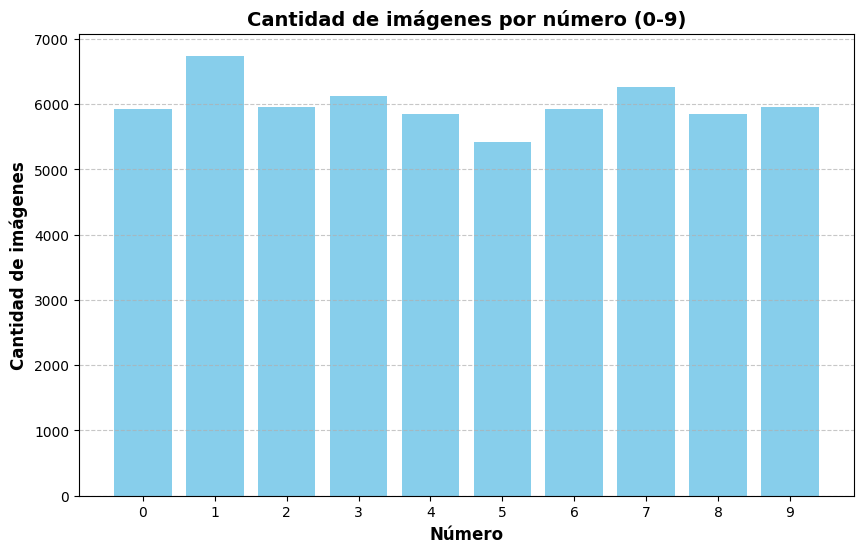

In [96]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(numimagen)), numimagen, color='skyblue')
plt.title('Cantidad de imágenes por número (0-9)', fontsize=14, fontweight="bold")
plt.xlabel('Número', fontsize=12, fontweight="bold")
plt.ylabel('Cantidad de imágenes', fontsize=12, fontweight="bold")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(10))
plt.show()

Las imágenes del dataset están relativamente balanceadas entre las 10 clases. La clase con más ejemplos es el número 1 (6742 imágenes) y la que menos tiene es el número 5 (5421 imágenes). Aunque hay pequeñas diferencias, la distribución es lo suficientemente equilibrada como para entrenar modelos sin riesgo significativo de sesgo hacia una clase específica.

# Definición del modelo base

1. explicacion m,n,c
2. explicacion seed
3. explicacion cantidad de capas ocupltas y su valor
4. cantidad de epocas
5. explicacion de funcion loss (si categorical_crossentropy no binary_corss)
5. eleccion de optimizadores (sgd y adam)
6. eleccion de avticadores con sus ventajas (relu y elu)
6. con activacion (relu)
7. vs con avticacion (elu)
8. explicaion de comparacion de fun activacion
9. cambio bachsize y explicacion
10. cambio epocas y explicacion
11. drop out
12. comparacion mejor modelo sin regulacion y con


#Entrenamiento y ajuste de hiperparámetros

## M, N y C

In [97]:
M = X_train.shape[0]
N = X_train.shape[1]
C = y_train.shape[1]
print(M,N,C)

60000 784 10


M: Representa la cantidad de imagenes en el conjunto de entrenamiento: 60,000 imágenes de dígitos escritos a mano.

N: Cada imagen tiene 784 píxeles. Esto significa que las imagenes del conjunto de datos son de 28 x 28 píxeles aplanadas en un vector de 784 píxeles.

C: Es la cantidad de clases posibles (dígitos escritos a mano del 0 al 9). Por eso, cada etiqueta en y_train está codificada en one-hot, usando un vector de 10 posiciones con un 1 en la clase correspondiente y 0 en las demás.

## Seeds

In [98]:
np.random.seed(29)
tf.random.set_seed(29)

Se fijaron semillas para asegurar que los resultados sean reproducibles. Es decir, que si se vuelve a ejecutar el mismo modelo, con los mismos datos y esta semilla, se obtendrán los mismos resultados.

## Capas ocultas y neuronas

In [99]:
h1 = 512
h2 = 256
h3 = 128

En el modelo de base utilizarán tres capas ocultas con 512, 256 y 128 neuronas respectivamente. Esta estructura descendente permite una reducción progresiva de la dimensionalidad, capturando patrones generales en las primeras capas y refinando características más específicas en las capas posteriores.

h1 = 512 Primera capa oculta tendrá 512 neuronas. Recibe los 784 pixeles de cada imagen de entrada.

h2 = 256 Segunda capa oculta tendrá 256 neuronas.

h3 = 128 Tercera capa oculta tendrá 128 neuronas.





## Épocas y batch size inicial

Como base, se utilizarán 10 épocas, ya que es una cantidad adecuada para que el modelo aprenda los patrones principales del dataset y se pueda evaluar si está aprendiendo correctamente sin llegar a sobreentrenarse. Esto permite un buen equilibrio entre la calidad del aprendizaje y el tiempo requerido para el entrenamiento. Además, se usará un batch size de 32 porque ofrece un buen rendimiento en cuanto a estabilidad y velocidad durante el proceso, sin exigir demasiados recursos del sistema.

## Función de perdida

Se utilizará categorical_crossentropy como función de pérdida debido a que el problema es de clasificación multiclase, en el que las etiquetas están representadas en formato one-hot encoding. En este formato, cada clase (dígito del 0 al 9) se codifica como un vector en el que solo una posición está activa, correspondiente a la clase correcta.

La función categorical_crossentropy mide la diferencia entre las probabilidades predichas por el modelo y las verdaderas distribuciones de clases. Su objetivo es minimizar la diferencia entre las predicciones del modelo y las clases reales, penalizando las predicciones incorrectas. Al utilizar esta función de pérdida, se busca que el modelo asigne la mayor probabilidad a la clase correcta, optimizando el aprendizaje en problemas de clasificación multiclase.               

🧠 ¿Qué hace categorical_crossentropy?
Compara la distribución real (las etiquetas reales, one-hot) con la distribución predicha por la red (salida del softmax).

Calcula cuánto se equivocó el modelo en su predicción.

📊 ¿Por qué no usar binary_crossentropy?
Porque binary_crossentropy es solo para clasificación binaria (2 clases: 0 o 1).
Aunque podrías usarlo en un problema multiclase si tratas cada clase como independiente (modo "one-vs-all"), no es lo óptimo ni lo esperado en MNIST.

## Explicacion de acticador softmax en capa de salida y pq no puede ser otro

🎯 ¿Qué hace softmax?
Convierte el vector de salida de la última capa (que puede tener cualquier valor real) en un vector de probabilidades, donde:

Cada valor está entre 0 y 1

La suma de todas las salidas da 1

La clase con mayor probabilidad es la que el modelo predice

📌 ¿Por qué softmax es la única opción válida aquí?
Porque estás resolviendo un problema de clasificación multiclase con una única clase por ejemplo (es decir, un dígito del 0 al 9 por imagen).

El modelo debe elegir una sola clase

softmax convierte las salidas en probabilidades mutuamente excluyentes

Y además, la función de pérdida categorical_crossentropy espera que la salida sea una distribución de probabilidad, lo que softmax garantiza.

✅ Conclusión
La activación softmax en la capa de salida es la única opción correcta para clasificación multiclase con one-hot encoding porque convierte las salidas en probabilidades comparables y sumables, permitiendo usar funciones como categorical_crossentropy y elegir la clase más probable.

##Explicacion de optimizadores a ocupar

SGD

✅ Ventajas:
Simple, fácil de implementar.

Buena generalización si se configura bien.

⚠️ Desventajas:
Puede ser lento en converger.

Puede oscilar mucho en terrenos con muchos mínimos o curvas irregulares.

Requiere ajustar muy bien el learning rate.

📌 Ideal para:
Casos simples o si quieres control total del aprendizaje.

A veces se mejora agregando momentum para suavizar los saltos.

Adam

✅ Ventajas:
Aprende más rápido en muchos casos.

Funciona bien con poco ajuste (learning rate por defecto: 0.001).

Se adapta automáticamente → útil en datasets ruidosos o variables.

⚠️ Desventajas:
A veces no generaliza tan bien como SGD.

Más complejo computacionalmente (pero en la práctica, no es un problema con hardware moderno).

📌 Ideal para:
Cuando necesitas resultados rápidos y estables.

Problemas más complejos o cuando no quieres afinar mucho a mano.


Optimizador	Ventajas	Desventajas	Cuándo usar
SGD	Simple, buena generalización	Lento, necesita tuning	Cuando tienes tiempo y control
Adam	Rápido, adaptable, fácil de usar	Puede sobreajustar en algunos casos	Para empezar, y problemas complejos

 ¿Cuál usar en MNIST?
Adam: funciona muy bien, rápido y eficaz.

SGD: útil si quieres experimentar o evitar sobreajuste.

✅ En práctica: muchos modelos actuales empiezan con Adam por su eficiencia.

##ExpLICACION DE METRICAS PARA EVALUAR LOS MODELOS

¡Súper buena observación! Es verdad que precision, recall y F1-score se definieron originalmente para clasificación binaria, pero sí se extienden perfectamente a problemas multiclase como MNIST.

✅ ¿Sirven para clasificación multiclase?
Sí, 100% sirven, y son muy comunes en problemas multiclase como MNIST.

🔍 ¿Cómo se adaptan?
En un problema con varias clases (como dígitos 0–9), se calcula una métrica por clase, tratándola como la clase positiva y al resto como negativas.

Por ejemplo:

Para calcular la precisión del dígito 3, se ve cuántas veces el modelo predijo 3 correctamente vs cuántas veces predijo 3 en total (aunque fueran errores).

Esto se hace para cada clase del 0 al 9.

📌 En resumen:

❓ Pregunta	✅ Respuesta
¿Son estas métricas solo para binario?	No, también sirven para multiclase
¿Se pueden usar con MNIST?	Sí, y es muy recomendable
¿Te dan valor agregado frente a accuracy?	Sí, muestran errores por clase

# Experimento 1: Optimizador SGD

## Activadores (Relu y Elu)

🧠 ¿Qué hace?
Si el valor de entrada es positivo, lo deja igual.

Si es negativo, lo convierte en 0.

✅ Ventajas:
Muy simple y eficiente.

Evita el problema del desvanecimiento del gradiente (que pasaba con activaciones como sigmoid o tanh).

Permite que el modelo aprenda rápido.

⚠️ Problema:
Algunas neuronas pueden "morir" (quedan siempre en 0 si reciben valores negativos constantemente). Esto puede hacer que ciertas neuronas dejen de aprender, a eso se le llama "neurona muerta".

🧠 ¿Qué hace?
Igual que ReLU para los valores positivos.

Pero en lugar de dar 0 a los negativos, les asigna un valor negativo suave (curvado), lo cual:

Permite que la red siga aprendiendo aunque reciba valores negativos.

Reduce el riesgo de neuronas muertas.

✅ Ventajas:
Más robusta para entrenamientos largos o redes más profundas.

Mejora la convergencia en algunos casos.

⚠️ Desventaja:
Más costosa computacionalmente que ReLU (usa exponenciales).

Si no está bien ajustado, puede introducir ruido en algunas situaciones

### Relu

In [100]:
red_sgd_relu = keras.Sequential(name="Red_sgd_relu")
red_sgd_relu.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_relu.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_sgd_relu.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_sgd_relu.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_sgd_relu.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_sgd_relu.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)

start_time = time()
hist_sgd_relu = red_sgd_relu.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_sgd_relu.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7467 - loss: 0.9539 - precision: 0.9132 - recall: 0.5125 - val_accuracy: 0.9230 - val_loss: 0.2675 - val_precision: 0.9457 - val_recall: 0.9057
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9262 - loss: 0.2541 - precision: 0.9473 - recall: 0.9083 - val_accuracy: 0.9424 - val_loss: 0.1974 - val_precision: 0.9569 - val_recall: 0.9300
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9452 - loss: 0.1902 - precision: 0.9588 - recall: 0.9323 - val_accuracy: 0.9521 - val_loss: 0.1610 - val_precision: 0.9626 - val_recall: 0.9433
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9557 - loss: 0.1524 - precision: 0.9659 - recall: 0.9465 - val_accuracy: 0.9575 - val_loss: 0.1388 - val_precision: 0.9661 - val_recall: 0.9505
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9631 - loss: 0.1269 - precision: 0.9713 - recall: 0.9559 - val_accuracy: 0.9622

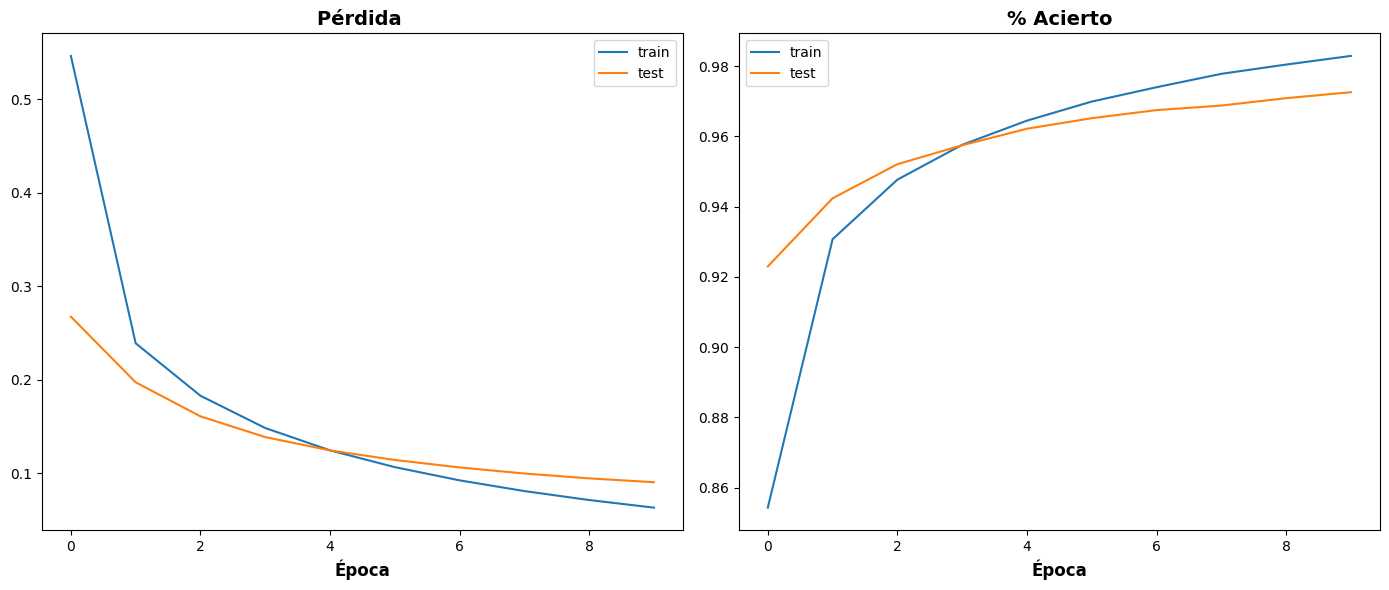

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_relu.history['loss'], label="train")
axs[0].plot(hist_sgd_relu.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_relu.history['accuracy'], label="train")
axs[1].plot(hist_sgd_relu.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


*COMENTARIO

### Elu

In [102]:
red_sgd_elu = keras.Sequential(name="red_sgd_elu")
red_sgd_elu.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_elu.add(keras.layers.Dense(h1, activation='elu',name='primera_capa'))
red_sgd_elu.add(keras.layers.Dense(h2, activation='elu',name='segunda_capa'))
red_sgd_elu.add(keras.layers.Dense(h3, activation='elu',name='tercera_capa'))
red_sgd_elu.add(keras.layers.Dense(C, activation='softmax', name='capa_salida'))

red_sgd_elu.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_sgd_elu = red_sgd_elu.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_elu.save("red_sgd_elu.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8146 - loss: 0.6992 - precision: 0.9356 - recall: 0.6539 - val_accuracy: 0.9191 - val_loss: 0.2850 - val_precision: 0.9402 - val_recall: 0.9011
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9201 - loss: 0.2776 - precision: 0.9399 - recall: 0.9030 - val_accuracy: 0.9317 - val_loss: 0.2383 - val_precision: 0.9468 - val_recall: 0.9191
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9326 - loss: 0.2305 - precision: 0.9487 - recall: 0.9204 - val_accuracy: 0.9407 - val_loss: 0.2023 - val_precision: 0.9534 - val_recall: 0.9298
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9439 - loss: 0.1951 - precision: 0.9564 - recall: 0.9332 - val_accuracy: 0.9482 - val_loss: 0.1761 - val_precision: 0.9589 - val_recall: 0.9387
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9511 - loss: 0.1692 - precision: 0.9619 - recall: 0.9421 - val_accuracy: 0.9538

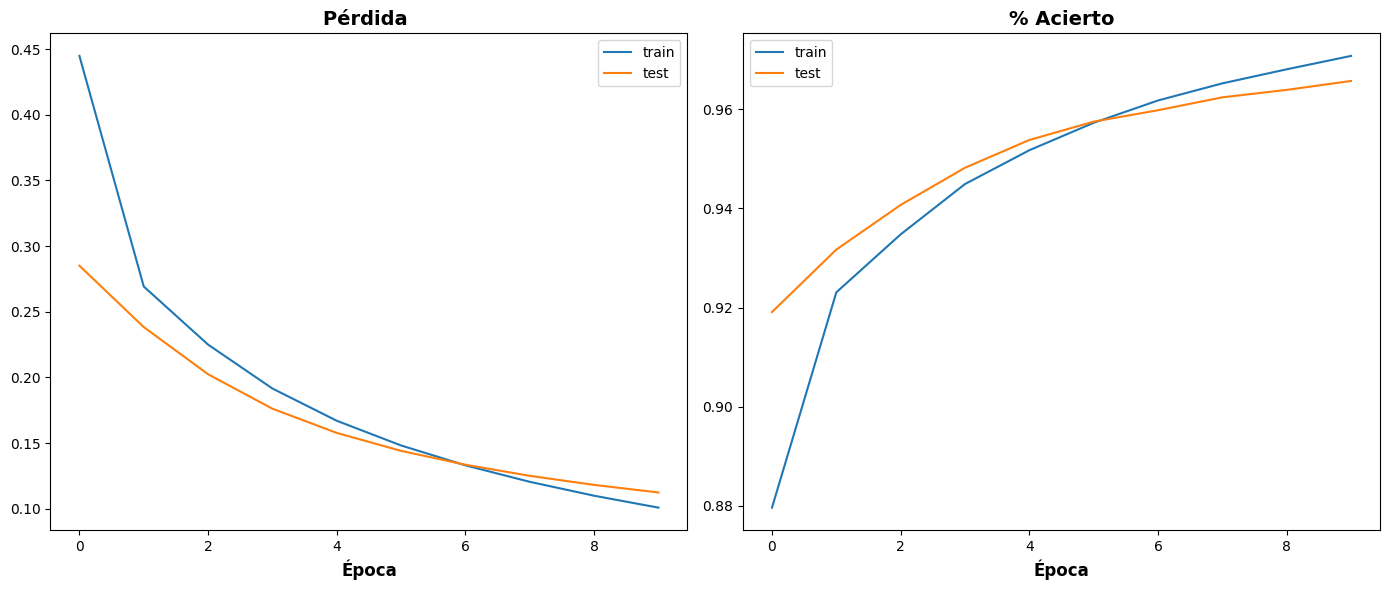

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_elu.history['loss'], label="train")
axs[0].plot(hist_sgd_elu.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_elu.history['accuracy'], label="train")
axs[1].plot(hist_sgd_elu.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


#CONCLUSIONES RELU VS ELU

In [104]:
relu_vs_elu = {
    'Métrica': list(hist_sgd_relu.history.keys()),
    'hist_relu': [hist_sgd_relu.history[k][-1] for k in hist_sgd_relu.history],
    'hist_elu': [hist_sgd_elu.history[k][-1] for k in hist_sgd_elu.history]
}


df = pd.DataFrame(relu_vs_elu)

display(df)

,Métrica,hist_relu,hist_elu
0,accuracy,0.982933,0.970750
1,loss,0.063294,0.100788
2,precision,0.986491,0.976263
3,recall,0.979767,0.965850
4,val_accuracy,0.972600,0.965700
5,val_loss,0.090494,0.112328
6,val_precision,0.976231,0.970425
7,val_recall,0.969300,0.961400


ReLU mostró una alta precisión en entrenamiento (0.9983) y una buena generalización en validación (0.9766), con una rápida convergencia (loss bajo). Sin embargo, existe el riesgo de "neuronas muertas", lo que puede afectar el aprendizaje en redes más profundas o con pesos mal inicializados.

ELU, en cambio, obtuvo resultados algo inferiores en ambas métricas (accuracy de 0.9705 en entrenamiento y 0.9643 en validación), con un mayor valor de pérdida, lo que indica una convergencia más lenta o menos eficiente. No obstante, su capacidad de producir salidas negativas ayuda a evitar el problema de las neuronas muertas, lo cual puede ser beneficioso en ciertos contextos o arquitecturas.

En resumen, ReLU se comportó mejor en este caso específico, pero ELU podría ofrecer ventajas en modelos más complejos o con problemas de desactivación de neuronas.

Ya que nuestro set de dato es simple nos eligirimos la funcion ReLU como funcion activadora para los siguientes cambios.

## Cambio batch size

### Batch size de 64

In [105]:
red_sgd_batch64 = keras.Sequential(name="red_sgd_bs64")
red_sgd_batch64.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_batch64.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_sgd_batch64.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_sgd_batch64.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_sgd_batch64.add(keras.layers.Dense(C, activation='softmax', name='capa_salida'))

red_sgd_batch64.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_sgd_batch64 = red_sgd_batch64.fit(X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))
red_sgd_batch64.save("red_sgd_batch64.keras")

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6525 - loss: 1.3271 - precision: 0.8695 - recall: 0.3159 - val_accuracy: 0.9044 - val_loss: 0.3421 - val_precision: 0.9386 - val_recall: 0.8693
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9091 - loss: 0.3255 - precision: 0.9407 - recall: 0.8764 - val_accuracy: 0.9263 - val_loss: 0.2577 - val_precision: 0.9469 - val_recall: 0.9063
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9273 - loss: 0.2537 - precision: 0.9474 - recall: 0.9077 - val_accuracy: 0.9370 - val_loss: 0.2185 - val_precision: 0.9528 - val_recall: 0.9229
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9386 - loss: 0.2149 - precision: 0.9543 - recall: 0.9222 - val_accuracy: 0.9451 - val_loss: 0.1923 - val_precision: 0.9574 - val_recall: 0.9326
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9454 - loss: 0.1877 - precision: 0.9600 - recall: 0.9327 - val_accuracy: 0.9501 - val_loss:

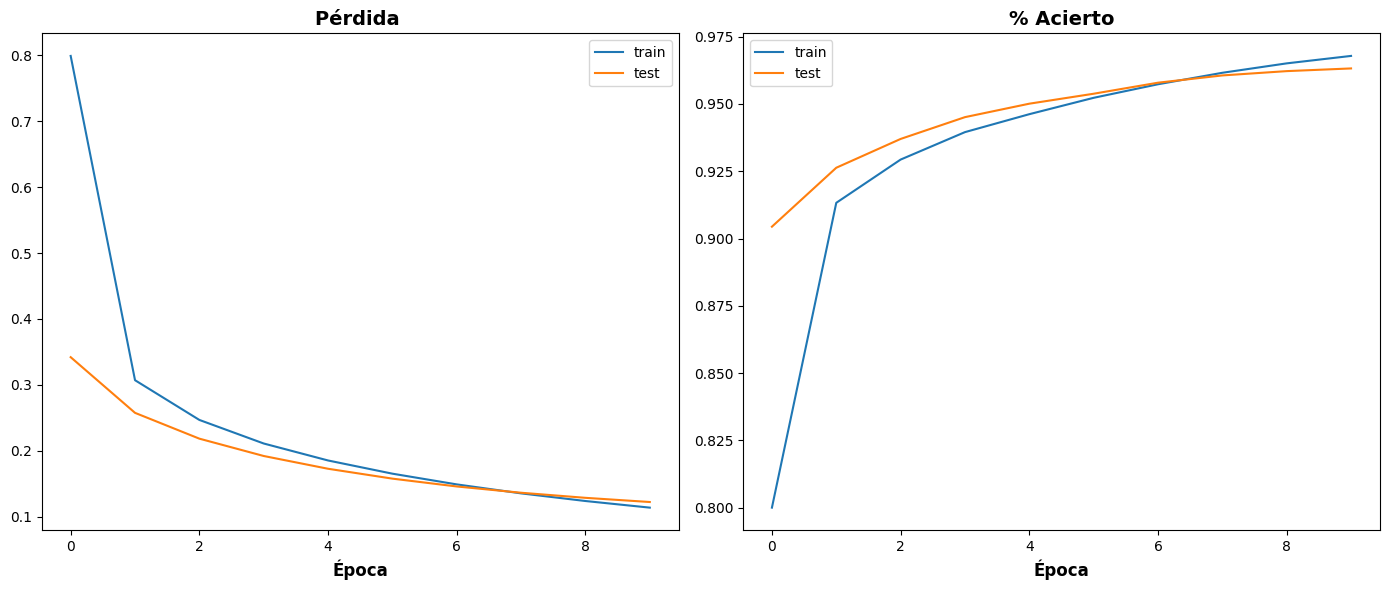

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_batch64.history['loss'], label="train")
axs[0].plot(hist_sgd_batch64.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_batch64.history['accuracy'], label="train")
axs[1].plot(hist_sgd_batch64.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


### Batch size de 256

In [107]:
red_sgd_batch256 = keras.Sequential(name="red_sgd_bs264")
red_sgd_batch256.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_batch256.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_sgd_batch256.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_sgd_batch256.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_sgd_batch256.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_sgd_batch256.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_sgd_batch256 = red_sgd_batch256.fit(X_train, y_train,
        epochs=10,
        batch_size=256,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))
red_sgd_batch256.save("red_sgd_batch256.keras")

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4408 - loss: 1.9564 - precision: 0.6656 - recall: 0.0274 - val_accuracy: 0.8187 - val_loss: 0.8462 - val_precision: 0.9747 - val_recall: 0.5017
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8303 - loss: 0.7304 - precision: 0.9623 - recall: 0.6033 - val_accuracy: 0.8775 - val_loss: 0.4781 - val_precision: 0.9444 - val_recall: 0.7962
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8769 - loss: 0.4634 - precision: 0.9435 - recall: 0.8025 - val_accuracy: 0.8954 - val_loss: 0.3798 - val_precision: 0.9388 - val_recall: 0.8522
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8955 - loss: 0.3799 - precision: 0.9386 - recall: 0.8487 - val_accuracy: 0.9064 - val_loss: 0.3331 - val_precision: 0.9393 - val_recall: 0.8732
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9058 - loss: 0.3370 - precision: 0.9397 - recall: 0.8715 - val_accuracy: 0.9136 - val_los

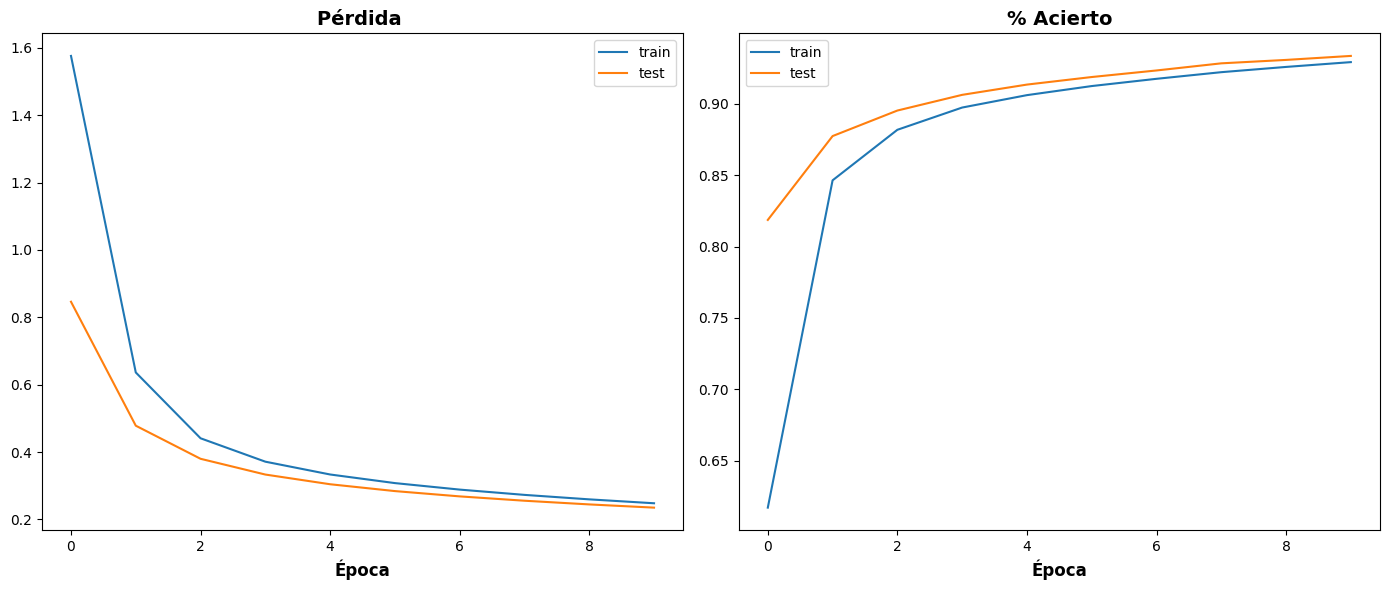

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_batch256.history['loss'], label="train")
axs[0].plot(hist_sgd_batch256.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_batch256.history['accuracy'], label="train")
axs[1].plot(hist_sgd_batch256.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


In [109]:
Batch_size_vs = {
    'Métrica': list(hist_sgd_relu.history.keys()),
    'batch size = 32': [hist_sgd_relu.history[k][-1] for k in hist_sgd_relu.history],
    'batch size = 64': [hist_sgd_batch64.history[k][-1] for k in hist_sgd_batch64.history],
    'batch size = 256': [hist_sgd_batch256.history[k][-1] for k in hist_sgd_batch256.history],
}

df_batch = pd.DataFrame(Batch_size_vs)

display(df_batch)

,Métrica,batch size = 32,batch size = 64,batch size = 256
0,accuracy,0.982933,0.967850,0.929350
1,loss,0.063294,0.113942,0.247794
2,precision,0.986491,0.974760,0.949709
3,recall,0.979767,0.960983,0.911167
4,val_accuracy,0.972600,0.963200,0.933700
5,val_loss,0.090494,0.122466,0.234806
6,val_precision,0.976231,0.970059,0.950974
7,val_recall,0.969300,0.959000,0.917500


El batch size más pequeño (32) produjo los mejores resultados tanto en entrenamiento como en validación. Tiene la mayor accuracy y val_accuracy, y las menores loss y val_loss A medida que el batch size aumenta, el rendimiento empeora:

La precisión (accuracy y val_accuracy) disminuye.

La pérdida (loss y val_loss) aumenta notablemente.

Batch sizes pequeños tienden a proporcionar un aprendizaje con mejores metricas (accuracy y perdida), ###al introducir más ruido estocástico que puede ayudar a salir de mínimos locales.

En cambio, batch sizes grandes pueden hacer que el modelo converja más rápido, pero a veces a soluciones menos óptimas. Pero batch sizes grandes pueden reducir el sobreentrenamiento, y se ve reflejado en la diferencia de accuracy y su validacion Batch size 32	con una diferencia de 0.0218, batch size de 64 con un diferencia de 0.0042 y batch size de 256 con una diferencia de 0.0050.

En conclucion:

Batch size pequeño (32): aprende muy bien, pero también tiende a memorizar más el entrenamiento con mayor riesgo de overfitting.

Batch size grande (256): aprende de forma más "estable", menos overfitting, pero también menor rendimiento o errores mas grandes

Ya que el sobre entrenmiento en nuestro caso no es tan grande nos quedaremos con un batch size de 32 ya que la perdida o el error es mucho mas bajo que los demas tamaños.

## Cambio de epochs

In [110]:
red_sgd_epoca = keras.Sequential(name="red_sgd_epoca")
red_sgd_epoca.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_epoca.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_sgd_epoca.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_sgd_epoca.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_sgd_epoca.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_sgd_epoca.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)
start_time = time()

hist_sgd_epoca = red_sgd_epoca.fit(X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))
red_sgd_epoca.save("red_sgd_epoca.keras")

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7307 - loss: 1.0021 - precision: 0.9091 - recall: 0.4891 - val_accuracy: 0.9217 - val_loss: 0.2778 - val_precision: 0.9418 - val_recall: 0.9024
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9239 - loss: 0.2631 - precision: 0.9453 - recall: 0.9054 - val_accuracy: 0.9402 - val_loss: 0.2064 - val_precision: 0.9533 - val_recall: 0.9273
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9420 - loss: 0.1990 - precision: 0.9563 - recall: 0.9296 - val_accuracy: 0.9506 - val_loss: 0.1672 - val_precision: 0.9616 - val_recall: 0.9412
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9535 - loss: 0.1607 - precision: 0.9635 - recall: 0.9436 - val_accuracy: 0.9591 - val_loss: 0.1421 - val_precision: 0.9666 - val_recall: 0.9503
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9612 - loss: 0.1336 - precision: 0.9690 - recall: 0.9541 - val_accuracy: 0.9627

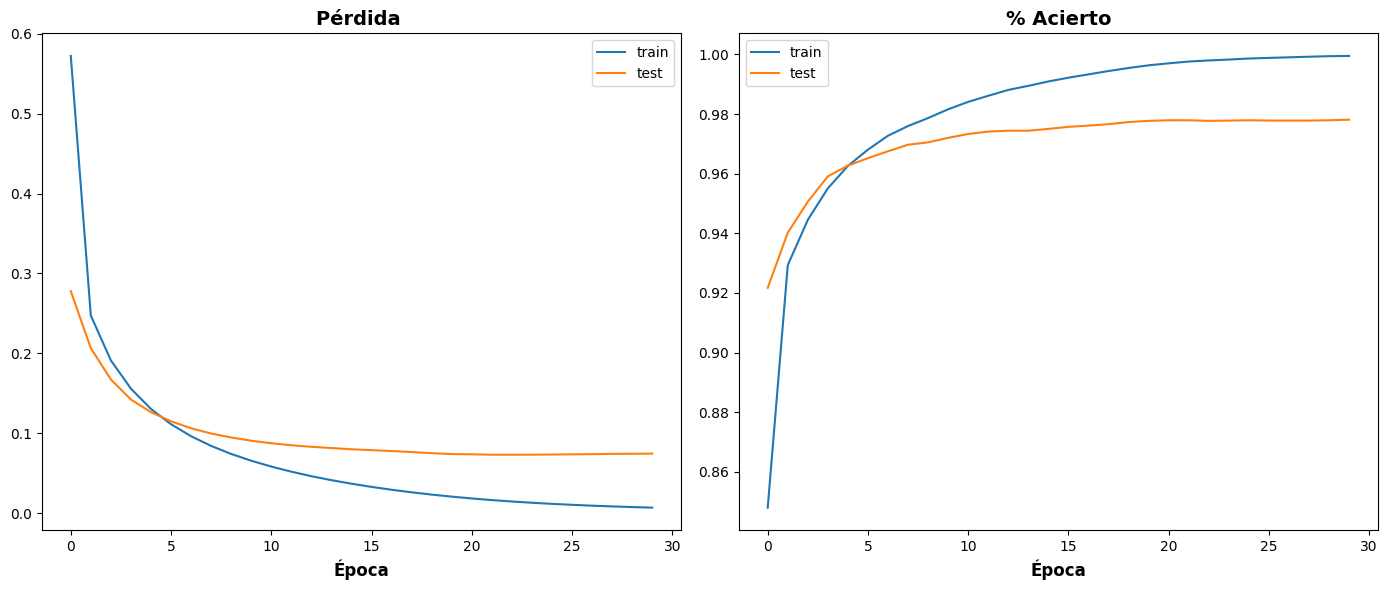

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_epoca.history['loss'], label="train")
axs[0].plot(hist_sgd_epoca.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_epoca.history['accuracy'], label="train")
axs[1].plot(hist_sgd_epoca.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()

In [112]:
Epoca_vs = {
    'Métrica': list(hist_sgd_relu.history.keys()),
    'Epoca = 10': [hist_sgd_relu.history[k][-1] for k in hist_sgd_relu.history],
    'Epoca = 30': [hist_sgd_epoca.history[k][-1] for k in hist_sgd_epoca.history],
    #'Epoca = 50': [.history[k][-1] for k in .history],
}

df_epoca = pd.DataFrame(Epoca_vs)

display(df_epoca)

,Métrica,Epoca = 10,Epoca = 30
0,accuracy,0.982933,0.999483
1,loss,0.063294,0.006788
2,precision,0.986491,0.999550
3,recall,0.979767,0.999367
4,val_accuracy,0.972600,0.978100
5,val_loss,0.090494,0.074499
6,val_precision,0.976231,0.979261
7,val_recall,0.969300,0.977400


Al aumentar las épocas de entrenamiento de 10 a 30, se observa una mejora general en todas las métricas.

El modelo logra una mayor precisión tanto en entrenamiento como en validación:

accuracy: sube ligeramente de 0.9984 → 0.9996

val_accuracy: también mejora, aunque de forma más modesta (0.9766 → 0.9787)

La pérdida (loss) disminuye en ambos conjuntos:

loss: se reduce casi a la mitad (0.0123 → 0.0068)

val_loss: también mejora, aunque de manera leve (0.0797 → 0.0778)

¡Buena pregunta! Aumentar la cantidad de épocas puede mejorar el rendimiento, pero también tiene costos y riesgos que vale la pena considerar. Te los explico:

⚖️ Costos de usar más épocas
1. 🕒 Mayor tiempo de entrenamiento
Cada época significa pasar una vez por todo el conjunto de datos, así que más épocas = más tiempo.

Esto puede ser costoso si:

El dataset es grande

Estás probando muchas configuraciones

Usas hardware limitado

2. 🧠 Riesgo de sobreentrenamiento (overfitting)
A partir de cierto punto, el modelo memoriza el conjunto de entrenamiento en vez de aprender a generalizar.

Esto se nota cuando:

accuracy sigue subiendo

pero val_accuracy se estanca o baja

y val_loss comienza a subir

En tu tabla, no se ve sobreentrenamiento aún, pero si entrenaras 100 épocas podrías empezar a verlo.

3. 💰 Mayor consumo de recursos
Más uso de GPU/CPU

Más energía (si entrenas en cloud, más costos)

Mayor desgaste de hardware si haces muchos ciclos largos

## Cambio de cantidad de capas

In [113]:
h4=64

red_sgd_capa4 = keras.Sequential(name="Red_sgd_4capas")
red_sgd_capa4.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_capa4.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_sgd_capa4.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_sgd_capa4.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_sgd_capa4.add(keras.layers.Dense(h4, activation='relu',name='cuarta_capa'))
red_sgd_capa4.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_sgd_capa4.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)
start_time = time()

hist_sgd_capa4 = red_sgd_capa4.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_capa4.save("red_sgd_capa4.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7147 - loss: 1.0147 - precision: 0.8831 - recall: 0.4958 - val_accuracy: 0.9245 - val_loss: 0.2553 - val_precision: 0.9433 - val_recall: 0.9094
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9304 - loss: 0.2352 - precision: 0.9482 - recall: 0.9161 - val_accuracy: 0.9460 - val_loss: 0.1793 - val_precision: 0.9571 - val_recall: 0.9376
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9507 - loss: 0.1701 - precision: 0.9621 - recall: 0.9405 - val_accuracy: 0.9578 - val_loss: 0.1431 - val_precision: 0.9656 - val_recall: 0.9506
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9621 - loss: 0.1334 - precision: 0.9692 - recall: 0.9544 - val_accuracy: 0.9639 - val_loss: 0.1236 - val_precision: 0.9697 - val_recall: 0.9580
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9695 - loss: 0.1086 - precision: 0.9749 - recall: 0.9632 - val_accuracy: 0.9675

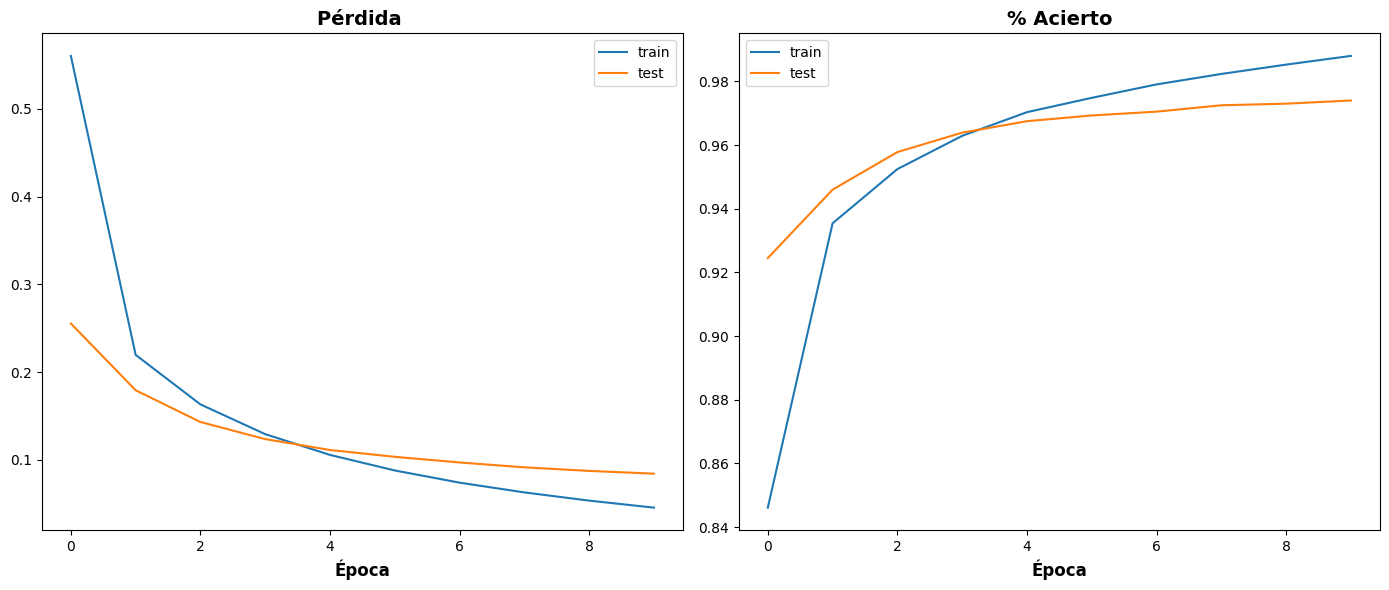

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_capa4.history['loss'], label="train")
axs[0].plot(hist_sgd_capa4.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_capa4.history['accuracy'], label="train")
axs[1].plot(hist_sgd_capa4.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()

In [115]:
Capas_vs = {
    'Métrica': list(hist_sgd_relu.history.keys()),
    'Capas = 3': [hist_sgd_relu.history[k][-1] for k in hist_sgd_relu.history],
    'Capas = 4': [hist_sgd_capa4.history[k][-1] for k in hist_sgd_capa4.history]
}

df_capas = pd.DataFrame(Capas_vs)

display(df_capas)

,Métrica,Capas = 3,Capas = 4
0,accuracy,0.982933,0.988000
1,loss,0.063294,0.045536
2,precision,0.986491,0.990094
3,recall,0.979767,0.986117
4,val_accuracy,0.972600,0.974000
5,val_loss,0.090494,0.084251
6,val_precision,0.976231,0.977085
7,val_recall,0.969300,0.972200


## Agregación de regulación (drop-out)

In [116]:
red_sgd_dropout = keras.Sequential(name="red_sgd_dropout")
red_sgd_dropout.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_dropout.add(keras.layers.Dense(h1, activation='relu'))
red_sgd_dropout.add(keras.layers.Dropout(0.3))
red_sgd_dropout.add(keras.layers.Dense(h2, activation='relu'))
red_sgd_dropout.add(keras.layers.Dense(h3, activation='relu'))
red_sgd_dropout.add(keras.layers.Dense(C, activation='softmax'))

red_sgd_dropout.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_sgd_dropout = red_sgd_dropout.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_sgd_dropout.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.6890 - loss: 1.0738 - precision: 0.8688 - recall: 0.4565 - val_accuracy: 0.9203 - val_loss: 0.2675 - val_precision: 0.9415 - val_recall: 0.9009
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9122 - loss: 0.2945 - precision: 0.9358 - recall: 0.8893 - val_accuracy: 0.9426 - val_loss: 0.1930 - val_precision: 0.9559 - val_recall: 0.9304
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9355 - loss: 0.2196 - precision: 0.9517 - recall: 0.9199 - val_accuracy: 0.9541 - val_loss: 0.1550 - val_precision: 0.9636 - val_recall: 0.9455
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9477 - loss: 0.1778 - precision: 0.9599 - recall: 0.9359 - val_accuracy: 0.9592 - val_loss: 0.1328 - val_precision: 0.9673 - val_recall: 0.9529
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9567 - loss: 0.1511 - precision: 0.9664 - recall: 0.9480 - val_accuracy: 0.9640

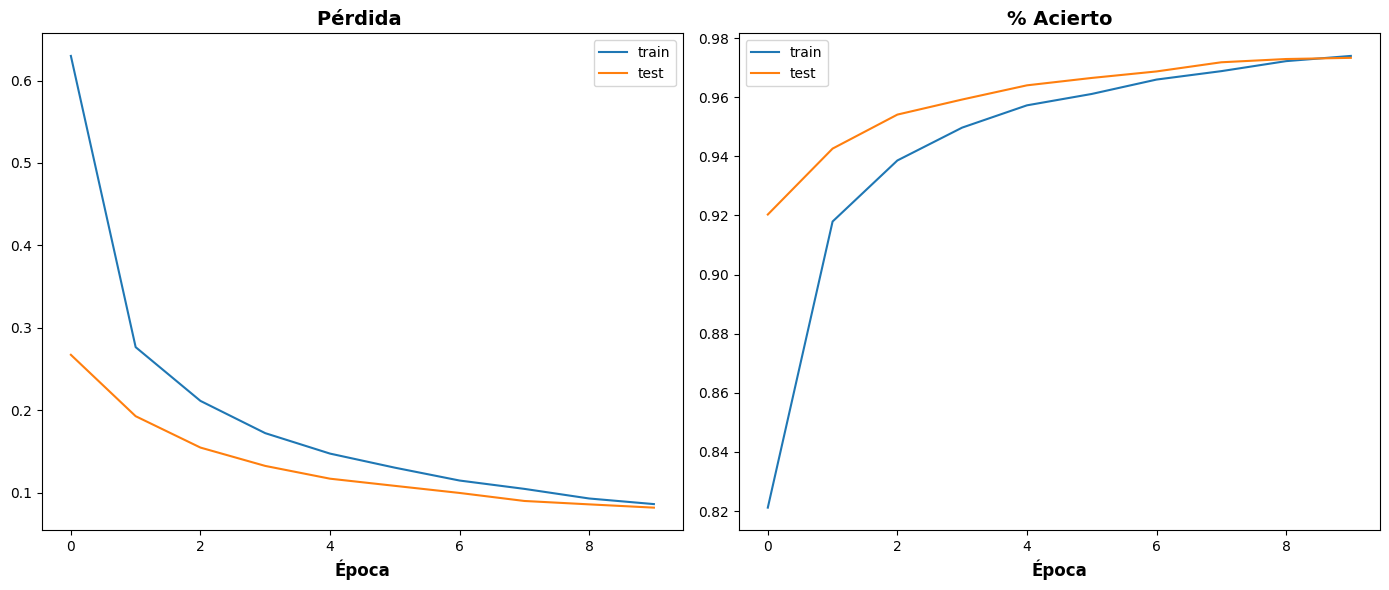

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_dropout.history['loss'], label="train")
axs[0].plot(hist_sgd_dropout.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_dropout.history['accuracy'], label="train")
axs[1].plot(hist_sgd_dropout.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


In [118]:
Dropout_vs = {
    'Métrica': list(hist_sgd_relu.history.keys()),
    'Sin DropOut': [hist_sgd_relu.history[k][-1] for k in hist_sgd_relu.history],
    'Con DropOut': [hist_sgd_dropout.history[k][-1] for k in hist_sgd_dropout.history]
}

df_dropout = pd.DataFrame(Dropout_vs)

display(df_dropout)

,Métrica,Sin DropOut,Con DropOut
0,accuracy,0.982933,0.973950
1,loss,0.063294,0.086500
2,precision,0.986491,0.978770
3,recall,0.979767,0.969683
4,val_accuracy,0.972600,0.973300
5,val_loss,0.090494,0.082206
6,val_precision,0.976231,0.976957
7,val_recall,0.969300,0.970900


## Mejor modelo

Para la selecion del mejor modelo utilizaremos la metrica

In [119]:
# Lista de modelos y sus historiales
modelos = [red_sgd_relu, red_sgd_elu, red_sgd_batch64, red_sgd_batch256, red_sgd_epoca, red_sgd_capa4, red_sgd_dropout]
historiales = [hist_sgd_relu, hist_sgd_elu, hist_sgd_batch64, hist_sgd_batch256, hist_sgd_epoca, hist_sgd_capa4, hist_sgd_dropout]

# Calcular diferencias absolutas entre accuracy y val_accuracy
diferencias_acc = [abs(h.history['accuracy'][-1] - h.history['val_accuracy'][-1]) for h in historiales]

# Encontrar el índice del modelo con menor diferencia
indice_mejor = diferencias_acc.index(min(diferencias_acc))

# Obtener el mejor modelo y sus métricas
mejor_modelo = modelos[indice_mejor]
nombre_mejor_modelo = mejor_modelo.name
hist_mejor = historiales[indice_mejor]

# Extraer métricas
acc = hist_mejor.history['accuracy'][-1]
val_acc = hist_mejor.history['val_accuracy'][-1]
loss = hist_mejor.history['loss'][-1]
val_loss = hist_mejor.history['val_loss'][-1]
recall = hist_mejor.history['recall'][-1]
precision = hist_mejor.history['precision'][-1]
f1_score = 2 * (precision * recall) / (precision + recall)


# Mostrar resultados
print(f"Mejor modelo según menor diferencia entre Accuracy y Val Accuracy:")
print(f"Modelo:         {nombre_mejor_modelo}")
print(f"Accuracy:       {acc:.4f}")
print(f"Val Accuracy:   {val_acc:.4f}")
print(f"Diferencia acc: {abs(acc - val_acc):.4f}")
print(f"Loss:           {loss:.4f}")
print(f"Val Loss:       {val_loss:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"F1 Score:       {f1_score:.4f}")

# Guardar el mejor modelo
mejor_modelo.save("modelo_mas_equilibrado.keras")


Mejor modelo según menor diferencia entre Accuracy y Val Accuracy:
Modelo:         red_sgd_dropout
Accuracy:       0.9740
Val Accuracy:   0.9733
Diferencia acc: 0.0007
Loss:           0.0865
Val Loss:       0.0822
Recall:         0.9697
Precision:      0.9788
F1 Score:       0.9742


# Experimento 2: Optimizador Adam

## Activadores (Relu y Elu)

### Relu

In [120]:
red_adam_relu = keras.Sequential(name="red_adam_relu")
red_adam_relu.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_relu.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_adam_relu.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_adam_relu.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_adam_relu.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_adam_relu.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_adam_relu = red_adam_relu.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )

end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_adam_relu.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8985 - loss: 0.3305 - precision: 0.9400 - recall: 0.8645 - val_accuracy: 0.9545 - val_loss: 0.1438 - val_precision: 0.9617 - val_recall: 0.9504
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9712 - loss: 0.0954 - precision: 0.9755 - recall: 0.9676 - val_accuracy: 0.9571 - val_loss: 0.1482 - val_precision: 0.9610 - val_recall: 0.9533
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9800 - loss: 0.0645 - precision: 0.9829 - recall: 0.9781 - val_accuracy: 0.9664 - val_loss: 0.1278 - val_precision: 0.9685 - val_recall: 0.9640
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9849 - loss: 0.0476 - precision: 0.9869 - recall: 0.9836 - val_accuracy: 0.9747 - val_loss: 0.0979 - val_precision: 0.9769 - val_recall: 0.9729
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9868 - loss: 0.0418 - precision: 0.9880 - recall: 0.9855 - val_accuracy: 0.9

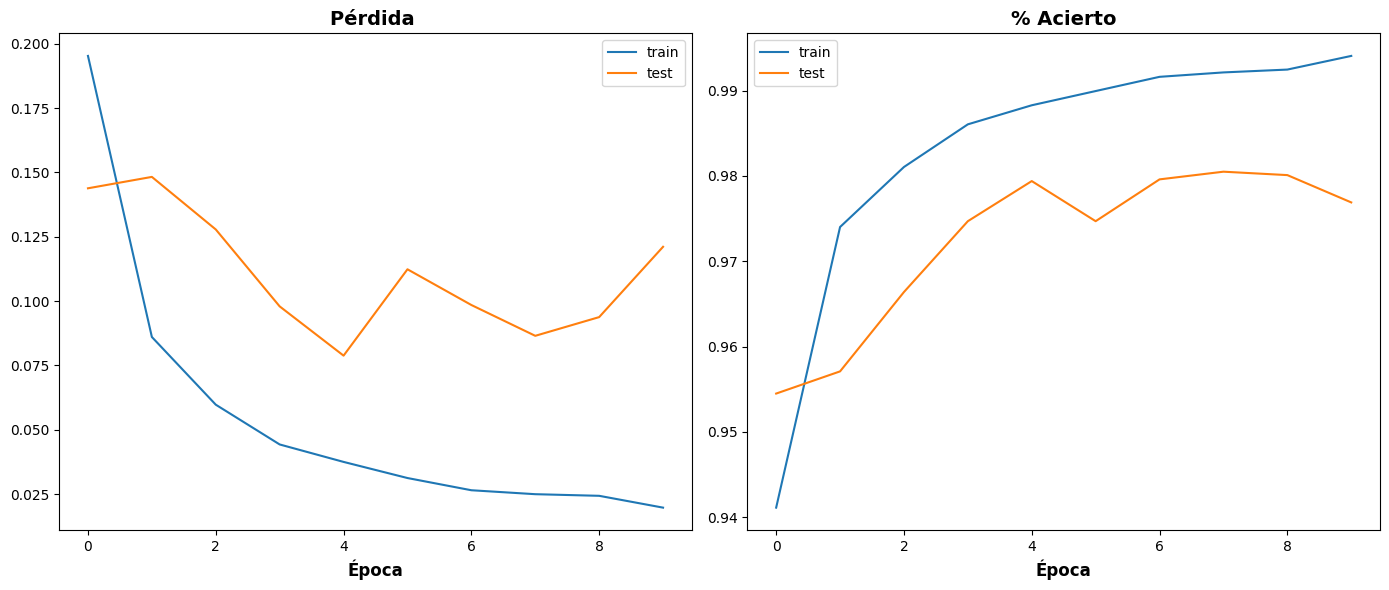

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

#axs.set_title('Activadores (Relu y Elu)', fontsize=14, fontweight="bold")

axs[0].plot(hist_adam_relu.history['loss'], label="train")
axs[0].plot(hist_adam_relu.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_adam_relu.history['accuracy'], label="train")
axs[1].plot(hist_adam_relu.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()


# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


### ELU

In [122]:
red_adam_elu = keras.Sequential(name="red_adam_elu")
red_adam_elu.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_elu.add(keras.layers.Dense(h1, activation='elu',name='primera_capa'))
red_adam_elu.add(keras.layers.Dense(h2, activation='elu',name='segunda_capa'))
red_adam_elu.add(keras.layers.Dense(h3, activation='elu',name='tercera_capa'))
red_adam_elu.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_adam_elu.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
   metrics=['accuracy','precision','recall']
)
start_time = time()
hist_adam_elu = red_adam_elu.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )

end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_adam_elu.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8951 - loss: 0.3420 - precision: 0.9244 - recall: 0.8723 - val_accuracy: 0.9562 - val_loss: 0.1509 - val_precision: 0.9634 - val_recall: 0.9496
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9617 - loss: 0.1221 - precision: 0.9663 - recall: 0.9583 - val_accuracy: 0.9568 - val_loss: 0.1476 - val_precision: 0.9626 - val_recall: 0.9525
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9722 - loss: 0.0873 - precision: 0.9754 - recall: 0.9699 - val_accuracy: 0.9651 - val_loss: 0.1192 - val_precision: 0.9681 - val_recall: 0.9624
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9778 - loss: 0.0714 - precision: 0.9801 - recall: 0.9760 - val_accuracy: 0.9672 - val_loss: 0.1138 - val_precision: 0.9702 - val_recall: 0.9648
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9819 - loss: 0.0585 - precision: 0.9835 - recall: 0.9804 - val_accuracy: 0.

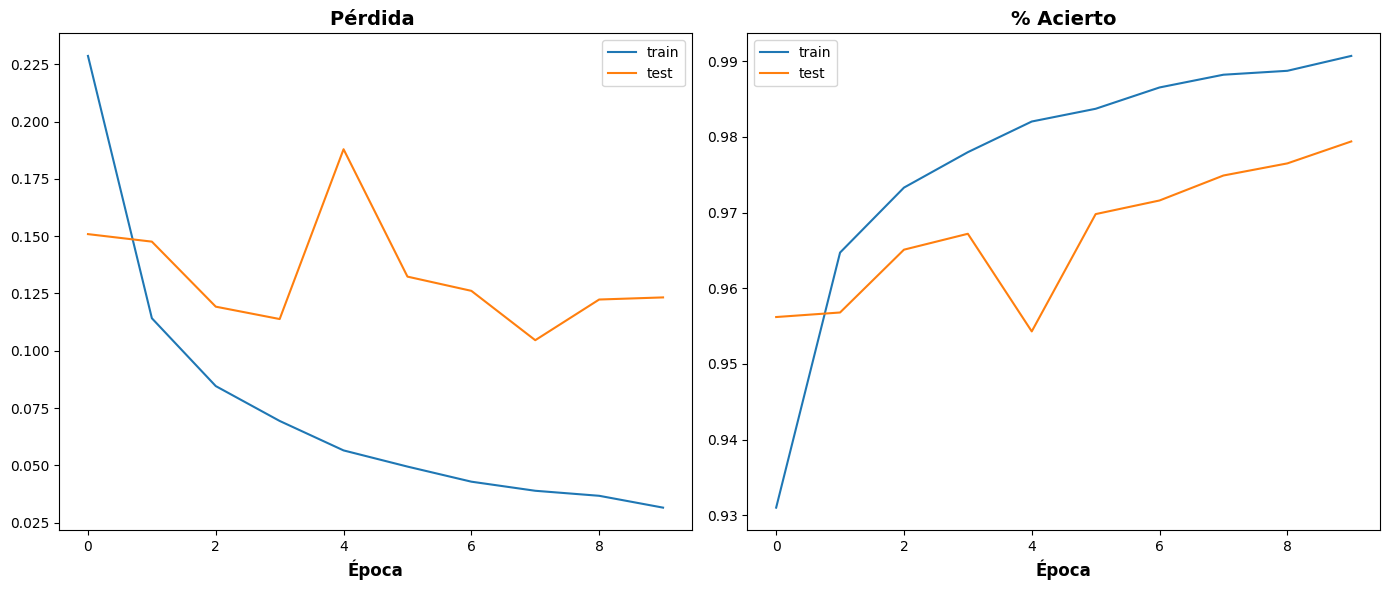

In [123]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_adam_elu.history['loss'], label="train")
axs[0].plot(hist_adam_elu.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_adam_elu.history['accuracy'], label="train")
axs[1].plot(hist_adam_elu.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


## Cambio Batch size

### Batch size de 64

In [124]:
red_adam_batch64 = keras.Sequential(name="red_adam_bs64")
red_adam_batch64.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_batch64.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_adam_batch64.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_adam_batch64.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_adam_batch64.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_adam_batch64.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_adam_batch64 = red_adam_batch64.fit(X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_adam_batch64.keras")

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8890 - loss: 0.3682 - precision: 0.9372 - recall: 0.8446 - val_accuracy: 0.9509 - val_loss: 0.1502 - val_precision: 0.9576 - val_recall: 0.9461
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9712 - loss: 0.0931 - precision: 0.9759 - recall: 0.9677 - val_accuracy: 0.9723 - val_loss: 0.0894 - val_precision: 0.9753 - val_recall: 0.9695
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9811 - loss: 0.0596 - precision: 0.9835 - recall: 0.9790 - val_accuracy: 0.9715 - val_loss: 0.1037 - val_precision: 0.9745 - val_recall: 0.9688
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9866 - loss: 0.0424 - precision: 0.9878 - recall: 0.9851 - val_accuracy: 0.9737 - val_loss: 0.0990 - val_precision: 0.9757 - val_recall: 0.9731
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9895 - loss: 0.0325 - precision: 0.9909 - recall: 0.9887 - val_accuracy: 0.9773 - va

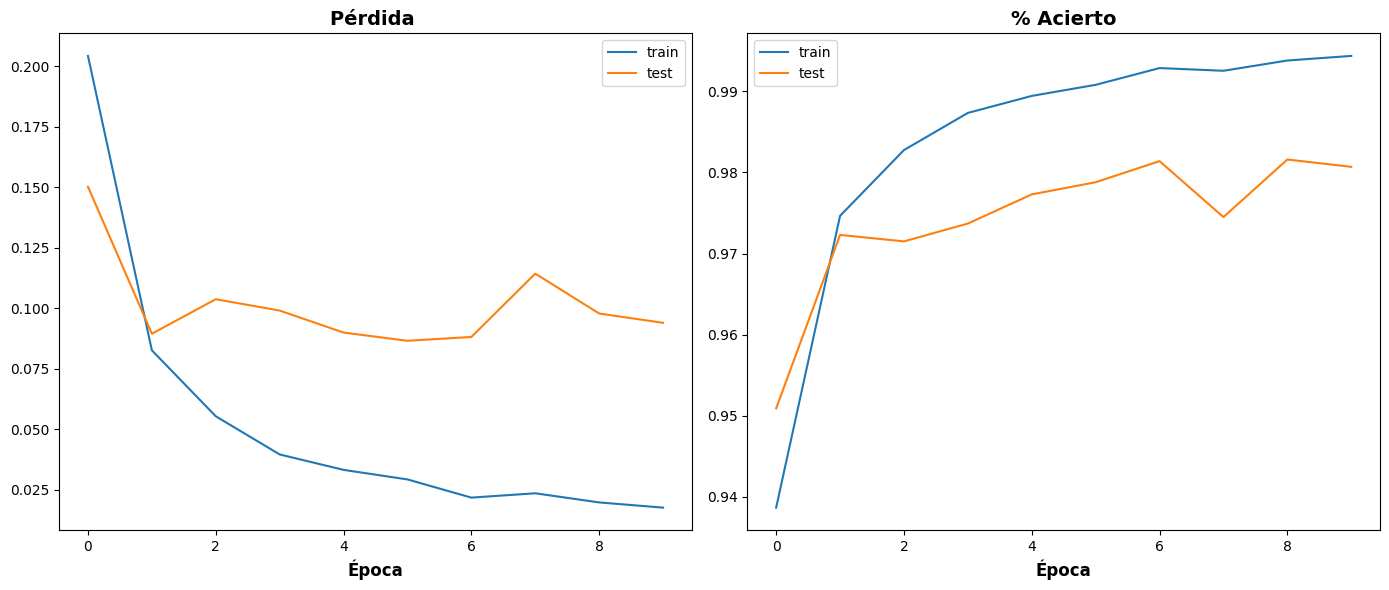

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_adam_batch64.history['loss'], label="train")
axs[0].plot(hist_adam_batch64.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_adam_batch64.history['accuracy'], label="train")
axs[1].plot(hist_adam_batch64.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()

### Batch Size 256

In [126]:
red_adam_batch256 = keras.Sequential(name="red_adam_bs32")
red_adam_batch256.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_batch256.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_adam_batch256.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_adam_batch256.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_adam_batch256.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_adam_batch256.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_adam_batch256 = red_adam_batch256.fit(X_train, y_train,
        epochs=10,
        batch_size=256,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_adam_batch256.keras")

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8492 - loss: 0.5361 - precision: 0.9222 - recall: 0.7566 - val_accuracy: 0.9595 - val_loss: 0.1290 - val_precision: 0.9672 - val_recall: 0.9543
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9684 - loss: 0.1044 - precision: 0.9739 - recall: 0.9636 - val_accuracy: 0.9714 - val_loss: 0.0873 - val_precision: 0.9752 - val_recall: 0.9697
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9812 - loss: 0.0627 - precision: 0.9847 - recall: 0.9787 - val_accuracy: 0.9755 - val_loss: 0.0803 - val_precision: 0.9781 - val_recall: 0.9733
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9871 - loss: 0.0419 - precision: 0.9891 - recall: 0.9854 - val_accuracy: 0.9745 - val_loss: 0.0855 - val_precision: 0.9764 - val_recall: 0.9733
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9901 - loss: 0.0311 - precision: 0.9915 - recall: 0.9891 - val_accuracy: 0.9717 - val_los

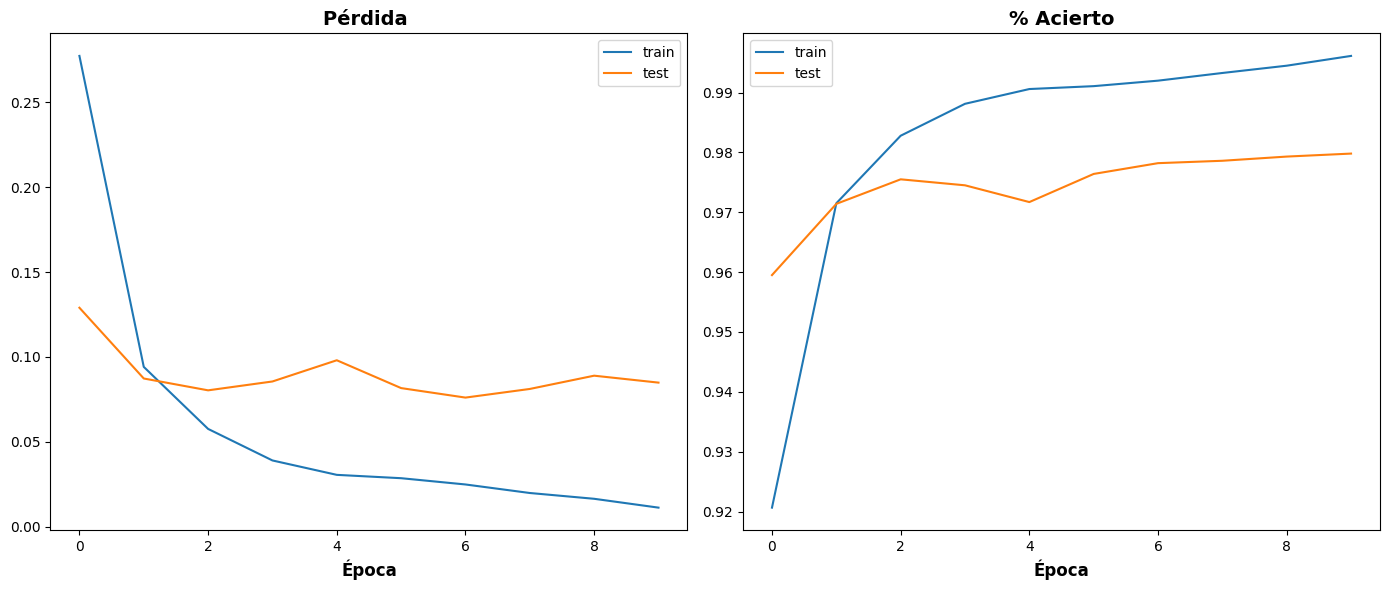

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_adam_batch256.history['loss'], label="train")
axs[0].plot(hist_adam_batch256.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acier256
axs[1].plot(hist_adam_batch256.history['accuracy'], label="train")
axs[1].plot(hist_adam_batch256.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()



## Cambio de epocas

In [128]:
red_adam_epoca = keras.Sequential(name="red_adam_epoca")
red_adam_epoca.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_epoca.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_adam_epoca.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_adam_epoca.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_adam_epoca.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_adam_epoca.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall']
)
start_time = time()

hist_adam_epoca = red_adam_epoca.fit(X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_test,y_test)
       )

end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_adam_epoca.keras")

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9007 - loss: 0.3270 - precision: 0.9390 - recall: 0.8667 - val_accuracy: 0.9606 - val_loss: 0.1241 - val_precision: 0.9677 - val_recall: 0.9551
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9708 - loss: 0.0942 - precision: 0.9748 - recall: 0.9675 - val_accuracy: 0.9642 - val_loss: 0.1248 - val_precision: 0.9677 - val_recall: 0.9602
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9797 - loss: 0.0643 - precision: 0.9822 - recall: 0.9776 - val_accuracy: 0.9711 - val_loss: 0.1026 - val_precision: 0.9740 - val_recall: 0.9690
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9851 - loss: 0.0467 - precision: 0.9871 - recall: 0.9832 - val_accuracy: 0.9739 - val_loss: 0.0969 - val_precision: 0.9762 - val_recall: 0.9722
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9881 - loss: 0.0380 - precision: 0.9894 - recall: 0.9870 - val_accuracy: 0.

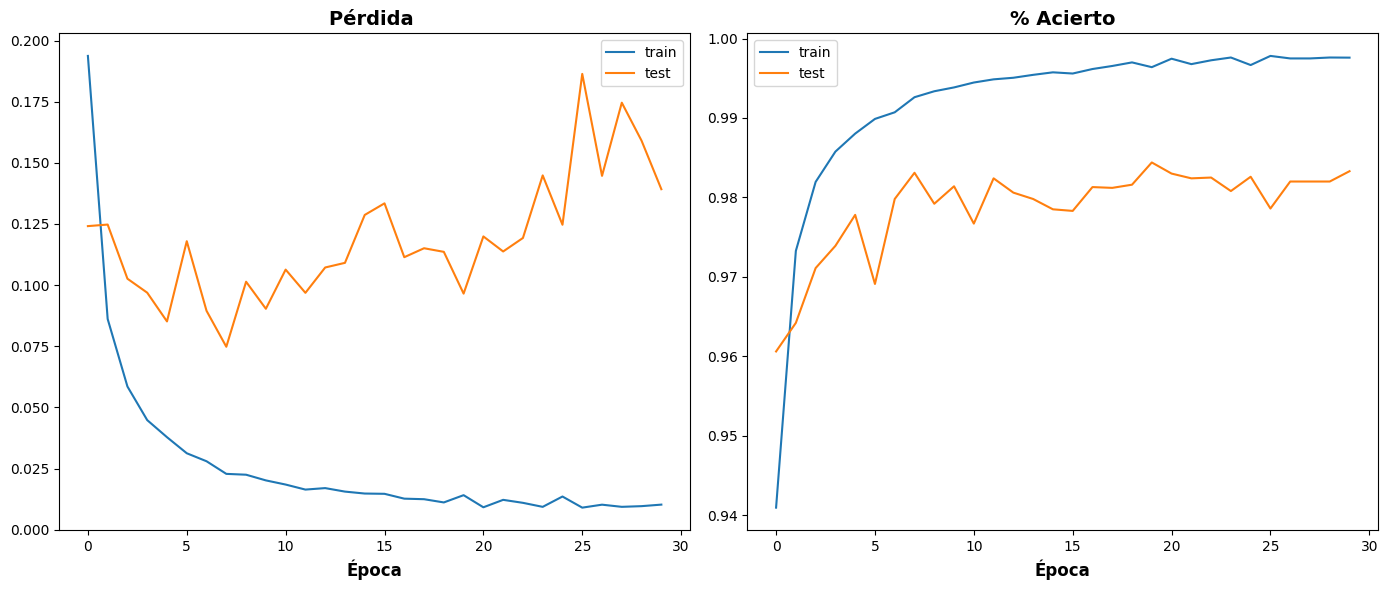

In [129]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_adam_epoca.history['loss'], label="train")
axs[0].plot(hist_adam_epoca.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_adam_epoca.history['accuracy'], label="train")
axs[1].plot(hist_adam_epoca.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()

## Cambio cantidad de capas

In [130]:
h4=64

red_adam_capa4 = keras.Sequential(name="Red_adam_4capas")
red_adam_capa4.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_capa4.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_adam_capa4.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_adam_capa4.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_adam_capa4.add(keras.layers.Dense(h4, activation='relu',name='cuarta_capa'))
red_adam_capa4.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_adam_capa4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall']
)
start_time = time()

hist_adam_capa4 = red_adam_capa4.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )

end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))
red_adam_capa4.save("red_sgd_capa4.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.8915 - loss: 0.3490 - precision: 0.9342 - recall: 0.8562 - val_accuracy: 0.9552 - val_loss: 0.1357 - val_precision: 0.9621 - val_recall: 0.9507
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9699 - loss: 0.1023 - precision: 0.9746 - recall: 0.9649 - val_accuracy: 0.9697 - val_loss: 0.1021 - val_precision: 0.9743 - val_recall: 0.9673
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9793 - loss: 0.0684 - precision: 0.9822 - recall: 0.9764 - val_accuracy: 0.9732 - val_loss: 0.1005 - val_precision: 0.9763 - val_recall: 0.9710
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9844 - loss: 0.0529 - precision: 0.9869 - recall: 0.9823 - val_accuracy: 0.9722 - val_loss: 0.1021 - val_precision: 0.9763 - val_recall: 0.9708
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9870 - loss: 0.0420 - precision: 0.9884 - recall: 0.9855 - val_accuracy: 0

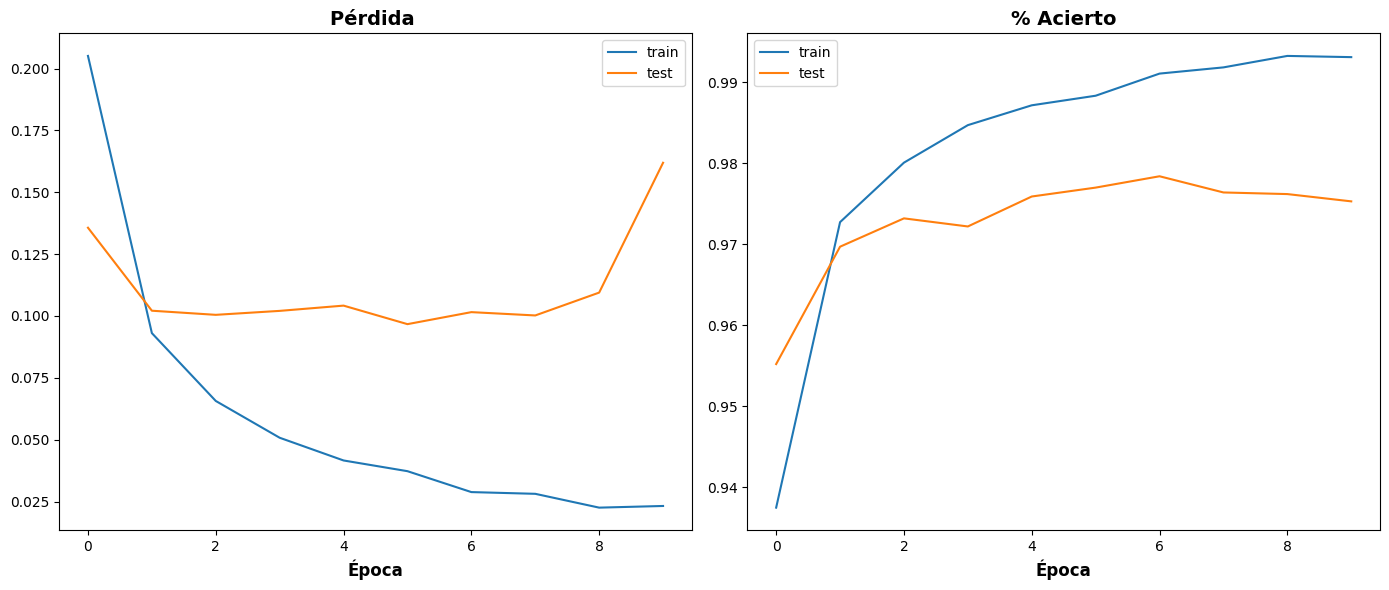

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_adam_capa4.history['loss'], label="train")
axs[0].plot(hist_adam_capa4.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_adam_capa4.history['accuracy'], label="train")
axs[1].plot(hist_adam_capa4.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()

## Agregación de regulación (drop-out)

In [132]:
red_adam_dropout= keras.Sequential(name="red_adam_dropout")
red_adam_dropout.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_dropout.add(keras.layers.Dense(h1, activation='relu'))
red_adam_dropout.add(keras.layers.Dropout(0.3))
red_adam_dropout.add(keras.layers.Dense(h2, activation='relu'))
red_adam_dropout.add(keras.layers.Dense(h3, activation='relu'))
red_adam_dropout.add(keras.layers.Dense(C, activation='softmax'))

red_adam_dropout.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_adam_dropout = red_adam_dropout.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )

end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_adam_dropout.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8841 - loss: 0.3792 - precision: 0.9278 - recall: 0.8426 - val_accuracy: 0.9639 - val_loss: 0.1169 - val_precision: 0.9708 - val_recall: 0.9578
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9619 - loss: 0.1249 - precision: 0.9688 - recall: 0.9566 - val_accuracy: 0.9701 - val_loss: 0.0935 - val_precision: 0.9740 - val_recall: 0.9669
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9696 - loss: 0.1007 - precision: 0.9744 - recall: 0.9657 - val_accuracy: 0.9747 - val_loss: 0.0859 - val_precision: 0.9783 - val_recall: 0.9720
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9755 - loss: 0.0805 - precision: 0.9788 - recall: 0.9721 - val_accuracy: 0.9735 - val_loss: 0.0882 - val_precision: 0.9755 - val_recall: 0.9719
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9781 - loss: 0.0704 - precision: 0.9807 - recall: 0.9760 - val_accuracy: 0

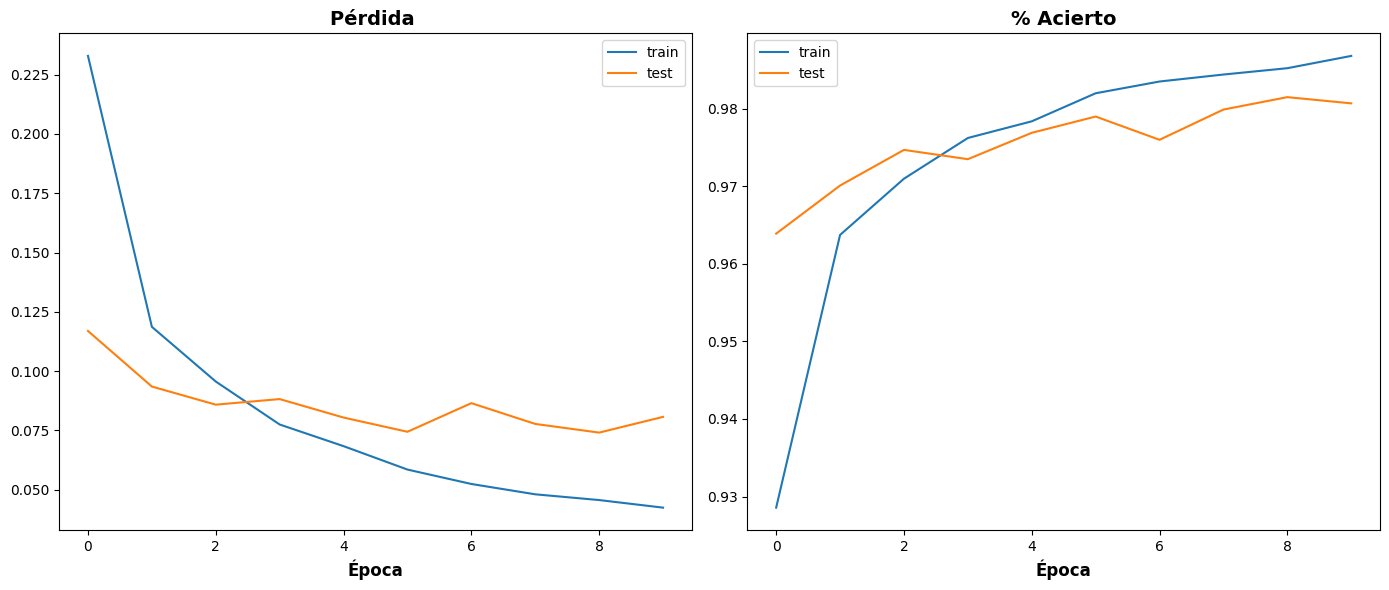

In [133]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_adam_dropout.history['loss'], label="train")
axs[0].plot(hist_adam_dropout.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_adam_dropout.history['accuracy'], label="train")
axs[1].plot(hist_adam_dropout.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()

## Mejor modelo

In [134]:
# Lista de modelos y sus historiales
modelos_adam = [red_adam_relu, red_adam_elu, red_adam_batch64, red_adam_batch256, red_adam_epoca, red_adam_capa4, red_adam_dropout]
historiales_adam = [hist_adam_relu, hist_adam_elu, hist_adam_batch64, hist_adam_batch256, hist_adam_epoca, hist_adam_capa4, hist_adam_dropout]
# Calcular diferencias absolutas entre accuracy y val_accuracy
diferencias_acc = [abs(h.history['accuracy'][-1] - h.history['val_accuracy'][-1]) for h in historiales_adam]

# Encontrar el índice del modelo con menor diferencia
indice_mejor = diferencias_acc.index(min(diferencias_acc))

# Obtener el mejor modelo y sus métricas
mejor_modelo = modelos_adam[indice_mejor]
nombre_mejor_modelo = mejor_modelo.name
hist_mejor = historiales_adam[indice_mejor]

# Extraer métricas
acc = hist_mejor.history['accuracy'][-1]
val_acc = hist_mejor.history['val_accuracy'][-1]
loss = hist_mejor.history['loss'][-1]
val_loss = hist_mejor.history['val_loss'][-1]
recall = hist_mejor.history['recall'][-1]
precision = hist_mejor.history['precision'][-1]
f1_score = 2 * (precision * recall) / (precision + recall)


# Mostrar resultados
print(f"Mejor modelo según menor diferencia entre Accuracy y Val Accuracy:")
print(f"Modelo:         {nombre_mejor_modelo}")
print(f"Accuracy:       {acc:.4f}")
print(f"Val Accuracy:   {val_acc:.4f}")
print(f"Diferencia acc: {abs(acc - val_acc):.4f}")
print(f"Loss:           {loss:.4f}")
print(f"Val Loss:       {val_loss:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"F1 Score:       {f1_score:.4f}")

# Guardar el mejor modelo
mejor_modelo.save("modelo_mas_equilibrado.keras")

Mejor modelo según menor diferencia entre Accuracy y Val Accuracy:
Modelo:         red_adam_dropout
Accuracy:       0.9868
Val Accuracy:   0.9807
Diferencia acc: 0.0061
Loss:           0.0425
Val Loss:       0.0807
Recall:         0.9856
Precision:      0.9880
F1 Score:       0.9868
